In [1]:
import sys
sys.path += ["../"]

import smbh
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.special import erf

from astropy.cosmology import FlatLambdaCDM#LambdaCDM
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Cosmology

In [2]:
cosmo = FlatLambdaCDM(H0 = 67.8, Om0 = 0.309)

In [3]:
SPEEDS = np.genfromtxt("../Week 13/initial.txt", delimiter = ', ', skip_header = 1)
AXIS = np.genfromtxt("../Week 13/axis.txt")

is_, a_1, a_2, a_3 = AXIS.T
js_, rv_x, rv_y, rv_z = SPEEDS.T

# Results

In [4]:
symmetric = np.genfromtxt("results.txt", skip_header = 1)

return_times = np.genfromtxt('../Week 13/return_times.txt')
return_masses = np.genfromtxt('../Week 13/return_masses.txt')
lyapunov = np.genfromtxt("../Week 13/lyapunov_exponents.txt")

# Global distributions

In [5]:
def gaussian(x, mu, std):
    v = std ** 2
    f = 1 / (2 * np.pi * v) ** 0.5
    exp = np.exp(- (x - mu) ** 2 / (2 * v))
    return f * exp

def gaussianInt(mu, std, a, b):
    v  = std ** 2
    e1 = erf((mu - a) / (2 * v) ** 0.5)
    e2 = erf((mu - b) / (2 * v) ** 0.5)
    return 0.5 * (e1 - e2)

def timeDist(x, mu1, std1, mu2, std2, a, b):
    return a * gaussian(np.log10(x), mu1, std1) + b * gaussian(np.log10(x), mu2, std2)

# def timeDist(x, mu1, std1):
#     return gaussian(np.log10(x), mu1, std1) / x

def timeInt(mu1, std1, mu2, std2, a, b, c, d):
    i1 = a * gaussianInt(mu1, std1, np.log10(c), np.log10(d))
    i2 = b * gaussianInt(mu2, std2, np.log10(c), np.log10(d))
    return i1 + i2

def plotHistogram(data, log = False, int_ = None, bins = None, density = True, ax = None, figsize = (8, 4.5),*args, **kwargs):
    if ax == None:
        fig, ax = plt.subplots(figsize = figsize)
    if bins == None:
        bins = int(np.ceil(len(data) ** 0.5))
    if log:
        freq, bins = np.histogram(np.log10(data), bins = bins, density = density)
        bins = 10 ** bins
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, np.log10(bins))
    else:
        freq, bins = np.histogram(data, bins = bins, density = density)
        db = np.diff(bins)
        bins = 0.5 * (bins[1:] + bins[:-1])
        freq = freq / np.trapz(freq, bins)

    if int_ != None:
        freq = freq / int_
        
    ax.bar(bins, freq, width = db, *args, **kwargs)
#     ax.plot(bins, freq)
    return ax, (bins, freq)

## Masses

In [6]:
masses = return_masses.flatten()

m_mu_t = masses.mean()
m_std_t = masses.std()

m_mu_s = symmetric[:, 1].mean()
m_std_s = symmetric[:, 1].std()

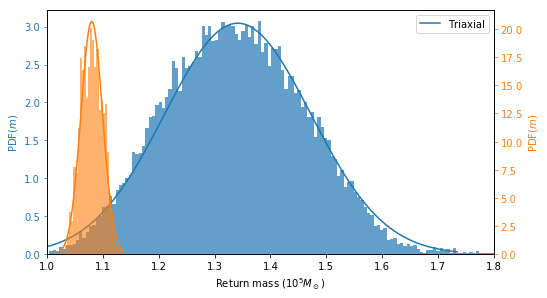

In [7]:
x1 = 3 * np.linspace(-1, 1, 100) * m_std_t + m_mu_t
x2 = 3 * np.linspace(-1, 1, 100) * m_std_s + m_mu_s

y1 = gaussian(x1, m_mu_t, m_std_t)
y2 = gaussian(x2, m_mu_s, m_std_s)

fig, ax1 = plt.subplots(figsize = (8, 4.5))

ax2 = ax1.twinx()

plotHistogram(masses, ax = ax1, alpha = 0.7)
ax1.plot(x1, y1)

plotHistogram(symmetric[:, 1], ax = ax2, alpha = 0.6, facecolor = COLOR_CYCLE[1])
ax2.plot(x2, y2, c = COLOR_CYCLE[1])

ax1.set_xlabel('Return mass ($10 ^ 5M_\odot$)')
ax1.set_ylabel(r'PDF$(m)$', color = COLOR_CYCLE[0])
ax1.tick_params('y', colors = COLOR_CYCLE[0])
ax2.set_ylabel(r'PDF$(m)$', color = COLOR_CYCLE[1])
ax2.tick_params('y', colors = COLOR_CYCLE[1])

ax1.set_xlim(1, 1.8)

ax1.legend(['Triaxial'])
# ax2.legend(['Spherical'])

fig.savefig('dist_masses.png', dpi = 300)

plt.show()

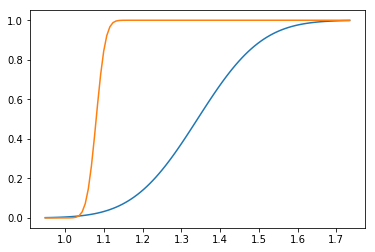

In [8]:
c_t = gaussianInt(m_mu_t, m_std_t, 0, x1)
c_s = gaussianInt(m_mu_s, m_std_s, 0, x1)
plt.plot(x1, c_t)
plt.plot(x1, c_s)

## Times

In [9]:
times = return_times.flatten()
pos = times != times.max()

times = 1000 * times[pos]

_, (t_bins_t, t_freq_t) = plotHistogram(times, log = True)
plt.close()
_, (t_bins_s, t_freq_s) = plotHistogram(1000 * symmetric[:, 0], log = True)
plt.close()

popt_t, pcov = curve_fit(timeDist, t_bins_t, t_freq_t, bounds = (([-np.inf, 0, -np.inf, 0] + [0] * 2), ([np.inf] * 4 + [1] * 2)))
popt_s, pcov = curve_fit(timeDist, t_bins_s, t_freq_s, bounds = (([-np.inf, 0, -np.inf, 0] + [0] * 2), ([np.inf] * 4 + [1] * 2)))

x = np.logspace(0, 5, 500)
# x = np.linspace(0, 1e6)
y_t = timeDist(x, *popt_t)
y_s = timeDist(x, *popt_s)

int_t = np.trapz(y_t, x = x)
int_s = np.trapz(y_s, x = x)
# popt_t[-2:] *= 1 / int_t
# popt_s[-2:] *= 1 / int_s

# y_t = y_t / int_t
# y_s = y_s / int_s

t_mu1_t, t_std1_t, t_mu2_t, t_std2_t, t_a_t, t_b_t = popt_t
t_mu1_s, t_std1_s, t_mu2_s, t_std2_s, t_a_s, t_b_s = popt_s

In [10]:
txt = r"""\hline
& \textbf{Spherical} & \textbf{Triaxial} \\
\hline"""
print(txt)

labels = ['$\mu_1$ $\log$(Myr)', '$\sigma_1$ $\log$(Myr)',
         '$\mu_2$ $\log$(Myr)', '$\sigma_1$ $\log$(Myr)',
         '$a$', '$b$']

for i in range(len(popt_t)):
    txt = r'%s & %f & %f\\' % (labels[i], popt_s[i], popt_t[i])
    print(txt)
print(r'\hline')

\hline
& \textbf{Spherical} & \textbf{Triaxial} \\
\hline
$\mu_1$ $\log$(Myr) & 1.360725 & 2.601585\\
$\sigma_1$ $\log$(Myr) & 0.270782 & 0.644694\\
$\mu_2$ $\log$(Myr) & 2.224283 & 1.806201\\
$\sigma_1$ $\log$(Myr) & 0.812581 & 0.230738\\
$a$ & 0.237471 & 0.759608\\
$b$ & 0.921093 & 0.251998\\
\hline


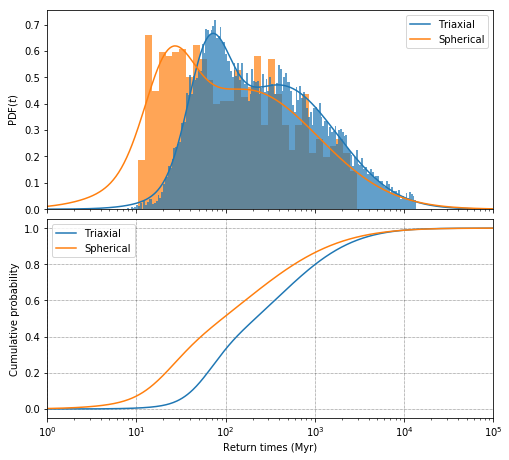

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (8, 7.5), sharex = True)

plotHistogram(1000 * symmetric[:, 0], log = True, ax = ax1, alpha = 0.7, facecolor = COLOR_CYCLE[1])
plotHistogram(times, log = True, ax = ax1, alpha = 0.7, facecolor = COLOR_CYCLE[0])

ax1.plot(x, y_t, c = COLOR_CYCLE[0], label = 'Triaxial')
ax1.plot(x, y_s, c = COLOR_CYCLE[1], label = 'Spherical')

ax1.set_ylabel(r'PDF$(t)$')

ax2.set_xlabel(r'Return times (Myr)')
ax2.set_ylabel(r'Cumulative probability')

ax1.legend()

# cumulative_t = [np.trapz(y_t[: i + 1], x = x[: i + 1]) for i in range(len(y_t))]
cumulative_t = timeInt(*popt_t, 1e-6, x)
cumulative_t = cumulative_t / max(cumulative_t)
ax2.plot(x, cumulative_t, label = 'Triaxial')

cumulative_s = timeInt(*popt_s, 1e-6, x)
cumulative_s = cumulative_s / max(cumulative_s)
# cumulative_s = [np.trapz(y_s[: i + 1], x = x[: i + 1]) for i in range(len(y_s))]
ax2.plot(x, cumulative_s, label = 'Spherical')

ax1.set_xscale("log")
ax2.legend()
ax2.grid()

ax1.set_xlim(x.min(), x.max())

fig.subplots_adjust(hspace = 0.05)

# fig.tight_layout()
fig.savefig('dist_times.png', dpi = 300)
plt.show()

# Relative properties:

In [12]:
r_t = return_times / symmetric[:, 0]
r_m = return_masses / symmetric[:, 1]
v = (rv_x ** 2 + rv_y ** 2 + rv_z ** 2) ** 0.5

In [13]:
T = (1 - (a_2 / a_1) ** 2) / (1 - (a_3 / a_1) ** 2)
pos = T.argsort()

In [14]:
colors = smbh.rgbToHex(smbh.getColors(len(T)))

color_m = np.zeros_like(return_times).astype(str)
vv = np.zeros_like(return_times)

for i, p in enumerate(pos):
    color_m[p, :] = colors[i]
    vv[p, :] = v

ts = r_t.flatten()
ms = r_m.flatten()
colors = color_m.flatten()
vv = vv.flatten()

ranges = np.linspace(v.min(), v.max(), 20)
p_ranges = [np.where((v >= ranges[i]) & (v < ranges[i + 1]))[0] for i in range(len(ranges) - 1)]

ts_mean = np.array([ts[pos].mean() for pos in p_ranges])
ts_std = np.array([ts[pos].std() for pos in p_ranges])
ms_mean = np.array([ms[pos].mean() for pos in p_ranges])
ms_std = np.array([ms[pos].std() for pos in p_ranges])

ranges = 0.5 * (ranges[1:] + ranges[:-1])

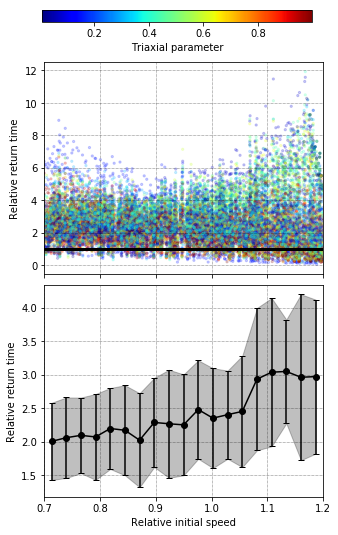

In [33]:
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (5, 8))

ax1.scatter(vv, ts, color = colors, alpha = 0.2, s = 5)

ax1.plot([0.7, 1.2], [1, 1], c = 'k', lw = 3)

cbaxes = fig.add_axes([0.12, 0.95, 0.75, 0.02])

sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = T.min(), vmax = T.max()))
sm._A = []
cb = fig.colorbar(sm, cax = cbaxes, orientation = 'horizontal')
cb.set_label('Triaxial parameter')

ax2.errorbar(ranges, ts_mean, ts_std, fmt = '-o', color = 'k', capsize = 3)
ax2.fill_between(ranges, ts_mean - ts_std, ts_mean + ts_std, color = 'k', alpha = 0.25)

ax1.set_xlim(0.7, 1.2)

ax2.set_xlabel('Relative initial speed')
ax1.set_ylabel('Relative return time')
ax2.set_ylabel('Relative return time')

ax1.grid()
ax2.grid()

fig.subplots_adjust(hspace = 0.05)

fig.savefig('relative_times.png', dpi = 300)

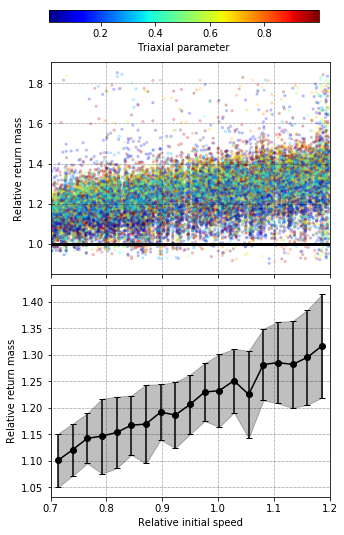

In [34]:
fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (5, 8))

ax1.scatter(vv, ms, color = colors, alpha = 0.2, s = 5)

ax1.plot([0.7, 1.2], [1, 1], c = 'k', lw = 3)

cbaxes = fig.add_axes([0.12, 0.95, 0.75, 0.02])

sm = plt.cm.ScalarMappable(cmap = 'jet', norm = plt.Normalize(vmin = T.min(), vmax = T.max()))
sm._A = []
cb = fig.colorbar(sm, cax = cbaxes, orientation = 'horizontal')
cb.set_label('Triaxial parameter')

ax2.errorbar(ranges, ms_mean, ms_std, fmt = '-o', color = 'k', capsize = 3)
ax2.fill_between(ranges, ms_mean - ms_std, ms_mean + ms_std, color = 'k', alpha = 0.25)

ax1.set_xlim(0.7, 1.2)

ax2.set_xlabel('Relative initial speed')
ax1.set_ylabel('Relative return mass')
ax2.set_ylabel('Relative return mass')

ax1.grid()
ax2.grid()

fig.subplots_adjust(hspace = 0.05)

fig.savefig('relative_mass.png', dpi = 300)

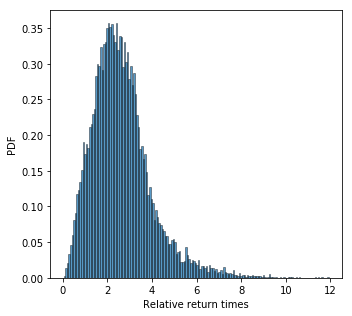

In [17]:
fig, ax = plt.subplots(figsize = (5, 4.5))

bins = int(np.ceil(len(ts) ** 0.5))

ax.hist(ts, bins = bins, density = True, linewidth = 0.5, edgecolor = 'k', alpha = 0.75)

ax.set_xlabel('Relative return times')
ax.set_ylabel('PDF')

fig.tight_layout()

fig.savefig("relative_times_dist.png", dpi = 300)

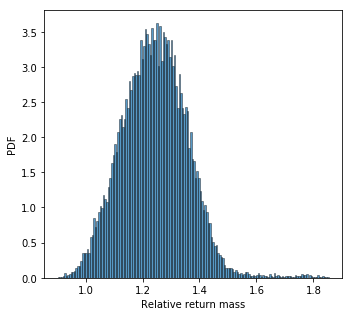

In [18]:
fig, ax = plt.subplots(figsize = (5, 4.5))

bins = int(np.ceil(len(ts) ** 0.5))

ax.hist(ms, bins = bins, density = True, linewidth = 0.5, edgecolor = 'k', alpha = 0.75)

ax.set_xlabel('Relative return mass')
ax.set_ylabel('PDF')

fig.tight_layout()

fig.savefig("relative_mass_dist.png", dpi = 300)

In [19]:
m0 = "ts = %.2f +- %.2f" % (ts.mean(), ts.std())
m1 = "ms = %.2f +- %.2f" % (ms.mean(), ms.std())
print(m0)
print(m1)

ts = 2.61 +- 1.34
ms = 1.24 +- 0.12


# Mass at

In [20]:
quasar_masses = np.genfromtxt("masses_at_time.txt")

In [21]:
qm = quasar_masses.flatten()

In [22]:
bins = int(np.ceil(len(qm) ** 0.35))

freq, bins = np.histogram(np.log10(qm * 10 ** 5), bins = bins, density = True)

bins = 10 ** bins
db = np.diff(bins)
bins = 0.5 * (bins[1:] + bins[:-1])

(a, b), cov = np.polyfit(np.log10(bins), np.log10(freq), 1, cov = True)

da = cov[0, 0] ** 0.5
dbb = cov[1, 1] ** 0.5

In [23]:
mf = 1e5 * np.exp((1 - 0.1) / (0.1 * 440) * 512)
print("%.1e" % mf)

3.5e+09


In [24]:
print(a, da)
print(b, dbb)

-0.7494264762088305 0.03020643780903455
3.848427574475211 0.21515187192794605


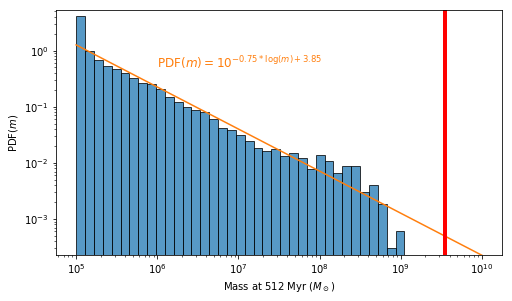

In [25]:
fig, ax = plt.subplots(figsize = (8, 4.5))

x = np.logspace(5, 10)
y = 10 ** (a * np.log10(x) + b)
ax.plot(x, y, color = COLOR_CYCLE[1])
ax.bar(bins, freq, width = db, alpha = 0.75, edgecolor = "k")

ax.plot([mf, mf], [1e-5, freq.max() * 1.25], c = 'r', lw = 4)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel("PDF$(m)$")
ax.set_xlabel("Mass at 512 Myr ($M_\odot$)")

ax.set_ylim(0.75 * freq.min(), 1.25 * freq.max())

ax.text(10 ** 6, 0.5, r"PDF$(m) = 10 ^ {%.2f * \log(m) + %.2f}$" % (a, b), color = COLOR_CYCLE[1], fontsize = 12)

fig.savefig('masses_at.png', dpi = 300)

plt.show()

In [26]:
def intProb(a, b, m0, m1, full = 1):
#     a = 1 + a
#     f = 10 ** b / a * (m1 ** a - m0 ** a)
    return (10 ** (a * m1 + b) - 10 ** (a * m0 + b)) / (a * np.log(10))
#     return f / full

In [27]:
full = intProb(a, b, 5, 9)

In [28]:
intProb(a, b, 8, np.log10(1e9), full) * 100

0.33955459361134177

In [29]:
intProb(a + da, b, 8, np.log10(1e9), full) * 100

0.6075725261601965

In [30]:
result = smbh.Results("../Week 13/Results/24_207.dat")

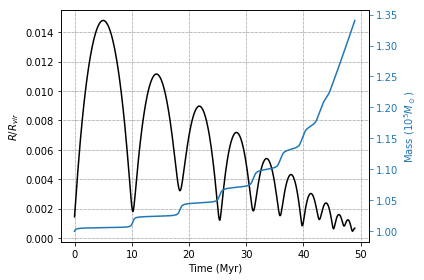

In [31]:
t = result.times * 1000
m = result.masses
d = result.distance / result.R_VIR

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(t, d, color = 'k')
ax2.plot(t, m)

ax1.set_xlabel('Time (Myr)')
ax1.set_ylabel('$R / R_{vir}$')
ax2.set_ylabel(r'Mass ($10^5 M_\odot$)', color = COLOR_CYCLE[0])
ax2.tick_params('y', colors = COLOR_CYCLE[0])

ax1.grid()

fig.tight_layout()

fig.savefig('mass_behavior.png', dpi = 300)

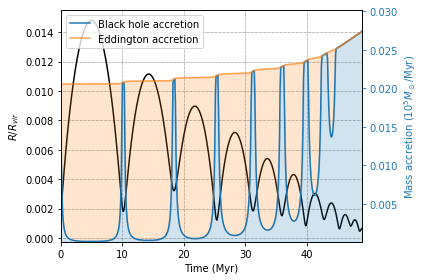

In [32]:
a = (1 - 0.1) / (0.1 * 440) * m

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
dt = 0.5 * (t[1:] + t[:-1])
dm = np.diff(m) / np.diff(t)

ax1.plot(t, d, color = 'k')
ax2.plot(dt, dm, label = 'Black hole accretion')

ax2.plot(t, a, label = 'Eddington accretion', alpha = 0.7)
ax2.fill_between(dt, dm, 0.5 * (a[1:] + a[:-1]), color = COLOR_CYCLE[1], alpha = 0.2)
ax2.fill_between(dt, 1e-4, dm, color = COLOR_CYCLE[0], alpha = 0.2)

ax2.legend()
# ax2.set_yscale('log')

ax1.set_xlabel('Time (Myr)')
ax1.set_ylabel('$R / R_{vir}$')
ax2.set_ylabel(r'Mass accretion ($10^5 M_\odot/$Myr)', color = COLOR_CYCLE[0])
ax2.tick_params('y', colors = COLOR_CYCLE[0])

ax1.grid()

ax1.set_xlim(t.min(), t.max())
ax2.set_ylim(1e-4, a.max() * 1.1)

fig.tight_layout()

fig.savefig('mass_accretion.png', dpi = 300)

# Orbits

In [59]:
n = 16

min_ = lyapunov[n].argmin()
rel = ((rv_x - rv_x[min_]) ** 2 + (rv_y - rv_y[min_]) ** 2 + (rv_z - rv_z[min_]) ** 2) ** 0.5
max_ = rel.argsort()[1]

r_min = smbh.Results('../Week 13/Results/%d_%d.dat' % (n, min_))
r_max = smbh.Results('../Week 13/Results/%d_%d.dat' % (n, max_))

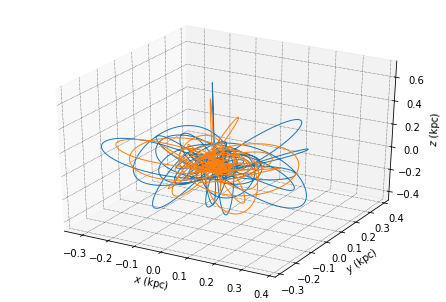

In [62]:
fig, ax = smbh.make3dPlot(r_min.positions)
fig, ax = smbh.make3dPlot(r_max.positions, fig_axes = (fig, ax))

fig.savefig('lyapunov_orbits.png', dpi = 300)

In [65]:
(rel[max_] / v[min_]) * 100

1.8636476219010898